# Dimension reduction practice

Here, we will look at some toy data with dimension reduction methods.

## PCA

We will discuss some intuition behind principal component analysis. Our data is made up of some collection of measurements -- for example, say we are analyzing cars, and the data available to us are the car's weight, fuel tank size, engine size, and fuel efficiency. Rather than selecting and discarding variables, PCA transforms the data so that each car is described as a new set of characteristics/variables, and each one is a _linear combination_ of the original measurements. That is, PCA variable 1 is some constant `a1` multiplied by `car_weight` plus some other constant `a2` multiplied by `fuel_tank_size`, etc. PCA variable 2 is some constant `b1` multiplied by `car_weight` plus some other constant `b2` multiplied by `fuel_tank_size`, etc. The value of these constants is calculated so that the new PCA variables show the highest possible variation between the original variables.

Geometrically, what PCA does is take our data and rotate the axes so that they now line up with the directions of largest variance. It creates a _new orthogonal coordinate system_ so that the data are now uncorrelated. If you imagine your data as some cloud of points, what PCA does is draw an ellipse around all of your points, and then draw the axes of that ellipse. These axes are your principal axes and the basis of your new coordinate system. The axes are ranked from longest to shortest, because the longest represents the dimension in which your data varies the most.

Mathematically all of this is done using eigenanalysis. The directions of your principal axes will be given by your eigenvectors, and the covariance matrix in your transformed data is given by the eigenvalues:

$$Cov(transformed) = diag(\lambda_{1}, \lambda_{2}, \dots, \lambda_{p})$$

Where you have $p$ principal axes and your eigenvalues are $\lambda_{1} \ge \lambda_{2} \ge \dots \ge \lambda_{p}$. The total variance of the transformed is given by the sum $\sum_{i}^{p}\lambda_{i}$, so the amount of variance explained by component $j$ is $\frac{\displaystyle \lambda_{j}}{\displaystyle \sum_{i}^{p}\lambda_{i}}$

$\frac{\lambda_{j}}{\sum_{i}^{p}\lambda_{i}}$

$\frac{\displaystyle \lambda_{j}}{\displaystyle \sum_{i}^{p}\lambda_{i}}$

Note that if your data exists in $N \times M$ dimensions, the number of principal axes will be the smaller of the two. There is an excellent discussion on the details and various intuition-based explanations [on a well-known stackexchange thread](https://stats.stackexchange.com/questions/2691/making-sense-of-principal-component-analysis-eigenvectors-eigenvalues).

### PCA with generated data

We can start with some artificial data to get an idea of what it means to rotate axes so that they explain the most variation.

In [82]:
# Set up so plots show up within the browser window
%matplotlib inline

# Import libraries
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms

In [93]:
# This is a helper function to draw an ellipse (https://matplotlib.org/devdocs/gallery/statistics/confidence_ellipse.html)
# (ie this is not actually part of PCA)
def confidence_ellipse(x, y, ax, n_std=3.0, facecolor='none', **kwargs):
    """
    Create a plot of the covariance confidence ellipse of *x* and *y*.

    Parameters
    ----------
    x, y : array-like, shape (n, )
        Input data.

    ax : matplotlib.axes.Axes
        The axes object to draw the ellipse into.

    n_std : float
        The number of standard deviations to determine the ellipse's radiuses.

    **kwargs
        Forwarded to `~matplotlib.patches.Ellipse`

    Returns
    -------
    matplotlib.patches.Ellipse
    """
    if x.size != y.size:
        raise ValueError("x and y must be the same size")

    cov = np.cov(x, y)
    pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])
    # Using a special case to obtain the eigenvalues of this
    # two-dimensionl dataset.
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = Ellipse((0, 0), width=ell_radius_x * 2, height=ell_radius_y * 2,
                      facecolor=facecolor, **kwargs)

    # Calculating the stdandard deviation of x from
    # the squareroot of the variance and multiplying
    # with the given number of standard deviations.
    scale_x = np.sqrt(cov[0, 0]) * n_std
    mean_x = np.mean(x)

    # calculating the stdandard deviation of y ...
    scale_y = np.sqrt(cov[1, 1]) * n_std
    mean_y = np.mean(y)

    transf = transforms.Affine2D() \
        .rotate_deg(45) \
        .scale(scale_x, scale_y) \
        .translate(mean_x, mean_y)

    ellipse.set_transform(transf + ax.transData)
    return ax.add_patch(ellipse)

In [94]:
# Fix a seed for reproducibility
random_seed = 202006
random_state = np.random.RandomState(random_seed)

# Generate our data
# Our data will be multivariate normal (2D) with mean vector (1,3) and covariance matrix ((7,5),(5,25))
X = random_state.multivariate_normal(mean = [1, 3], cov = [[7, 5],[5, 25]], size = 200)

(-7.710604925425679, 9.012471651290838, -11.056169720663865, 21.69637394272138)

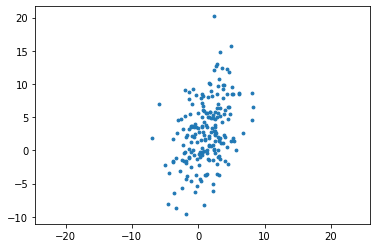

In [95]:
# Plot our data
plt.scatter(X[:,0], X[:,1], s=8)
plt.axis('equal')

In [48]:
# Transform our data using PCA
pca = PCA(n_components=2) # Create the PCA object in python
pca.fit(X) # Calculate the PC axes for the data we generated

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

We can look at the 

In [49]:
print(pca.explained_variance_)
print(pca.explained_variance_ratio_)

[[ 0.29542718  0.95536526]
 [ 0.95536526 -0.29542718]]
[21.44838318  6.00579433]
[0.78124297 0.21875703]


[(-20, 25), (-30, 30)]

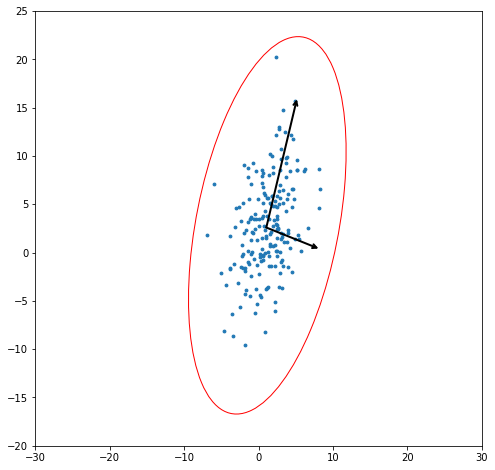

In [92]:
# Plot our data
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.scatter(X[:,0], X[:,1], s=8,)
confidence_ellipse(X[:,0], X[:,1], ax, edgecolor='red', n_std = 4)
for length, vector in zip(pca.explained_variance_, pca.components_):
    v = vector * 3 * np.sqrt(length)
    draw_vector(pca.mean_, pca.mean_ + v, ax=ax)
ax.set(xlim=(-30,30), ylim=(-20,25))

[Text(0, 0.5, 'PC2'), Text(0.5, 0, 'PC1'), Text(0.5, 1.0, 'Transformed data')]

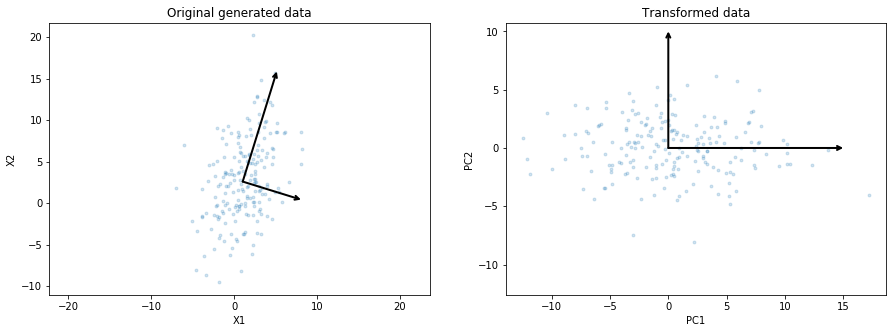

In [71]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

ax[0].scatter(X[:,0], X[:,1], alpha=0.2, s=8)
for length, vector in zip(pca.explained_variance_, pca.components_):
    v = vector * 3 * np.sqrt(length)
    draw_vector(pca.mean_, pca.mean_ + v, ax=ax[0])
ax[0].axis('equal');
ax[0].set(xlabel='X1', ylabel='X2', title='Original generated data')

# plot principal components
X_pca = pca.transform(X)
ax[1].scatter(X_pca[:, 0], X_pca[:, 1], alpha=0.2, s=8)
draw_vector([0, 0], [0, 10], ax=ax[1])
draw_vector([0, 0], [15, 0], ax=ax[1])
ax[1].axis('equal')
ax[1].set(xlabel='PC1', ylabel='PC2',
          title='Transformed data')

### PCA with toy data